# Artificial Neural Network for chest X-ray image detection
## Full training : VGG16 with 8 layers



Model was trained to distinguish 3 classes: (A) x-ray of the chest, (B) x-ray of other parts of the body and (C) any images
- Convolutional Neural network
- Transfer learning: VGG16 from the kernel 28
- The training was carried out with kfold = 10
- Each fold a new VGG16 was inserted
- batch_size = 10
- image shape = 299, 299
- epoch = 30

In [1]:
#Import from keras_preprocessing not from keras.preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import applications
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import pandas as pd
import numpy as np
import glob
from sklearn.model_selection import KFold
import datetime
from ilan import multiclass_metrics
import matplotlib.pyplot as plt

In [2]:
# with tf.device('/gpu:2'): #gpu 0 estava ocupada
img_width, img_height = 299, 299 
batch_size = 10

vgg16 = applications.VGG16(include_top=False, weights='imagenet',input_shape=(img_width, img_height, 3))
display(vgg16.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 299, 299, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 299, 299, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 299, 299, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 149, 149, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 149, 149, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 149, 149, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 74, 74, 128)       0     

None

In [3]:
# with tf.device('/gpu:3'): #gpu 0 estava ocupada
# Freeze n number of layers from the last
for layer in vgg16.layers[:-8]: layer.trainable = False

for layer in vgg16.layers: print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7ffed6606e10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffed5a60950> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffed521b790> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ffed4fa9f50> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffed477bd10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffed477b7d0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ffed419ac10> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffed41aa410> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffed41b2f90> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7ffed41b8dd0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x7ffed600e350> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 

In [5]:
# # Gerando dataframe de treino
# path = ['/scratch/v_project/diagnosticos/pre_processing/CNN/train/xray/*','/scratch/v_project/diagnosticos/pre_processing/CNN/train/chest_xray/*.png','/scratch/v_project/diagnosticos/pre_processing/CNN/train/no_xray/*.jpg']
# labels = ['xray','chest_xray','no_xray']
# for i in range(len(path)):
#     lista = glob.glob(path[i])
#     df = pd.DataFrame(lista,columns = ['id'])
#     df['label'] = labels[i]
#     if i == 0:
#         df_copy = df.copy()
#     else:
#         df_copy = pd.concat([df_copy,df])
# df_copy.to_csv('train.csv',index=False)

# # Gerando dataframe de teste
# path_test = ['/scratch/v_project/diagnosticos/pre_processing/CNN/test/xray/*','/scratch/v_project/diagnosticos/pre_processing/CNN/test/chest_xray/*.png','/scratch/v_project/diagnosticos/pre_processing/CNN/test/no_xray/*.jpg']
# labels_test = ['xray','chest_xray','no_xray']
# for i in range(len(path_test)):
#     lista_test = glob.glob(path_test[i])
#     df_test = pd.DataFrame(lista_test,columns = ['id'])
#     df_test['label'] = labels_test[i]
#     if i == 0:
#         df_test_copy = df_test.copy()
#     else:
#         df_test_copy = pd.concat([df_test_copy,df_test])
# df_test_copy.to_csv('test.csv',index=False)

# print('Quantidade de imagens de treino:',len(df_copy))
# print('Quantidade de imagens de teste:',len(df_test_copy))
# print('\nConcatenando imagens de treino e teste')
# dataframe = pd.concat([df_copy,df_test_copy])
# with tf.device('/gpu:3'): #gpu 0 estava ocupada
dataframe = pd.read_csv('dataframe.csv')
print('\nQuantidade total de imagens:',len(dataframe))


Quantidade total de imagens: 49382


In [8]:
# with tf.device('/gpu:3'): #gpu 0 estava ocupada
epochs = 30 

train_datagen = ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_dataframe(
dataframe=dataframe,
directory="./train/",
x_col="id",
y_col="label",
subset="training",
batch_size=batch_size,
shuffle=False,
class_mode="categorical",
target_size=(img_width, img_height))

num_classes = len(train_generator.class_indices) 
print('Quantidade de classes:',num_classes)
# get the class labels for the training data, in the original order 
train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)
# get the class labels for the training data, in the original order 
#     validation_labels = validation_generator.classes  
# convert the training labels to categorical vectors 
#     validation_labels = to_categorical(validation_labels, num_classes=num_classes)
# get the class labels for the training data, in the original order 

Found 49382 validated image filenames belonging to 3 classes.
Quantidade de classes: 3


In [5]:

#create the model
model = Sequential()
#Add the vgg convolutional base model
model.add(vgg16)
#ADd new layers
model.add(Flatten()) 
model.add(Dense(100, activation=tf.keras.layers.LeakyReLU(alpha=0.3))) 
#     model.add(Dropout(0.5)) 
model.add(Dense(50, activation=tf.keras.layers.LeakyReLU(alpha=0.3)))
#     model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))

display(model.summary())

print('Parametros do backlog')
csv_log = CSVLogger('Wholedataset_8layers')

filepath=('Wholedataset_8layers_{epoch:02d}_AC{acc:.3f}_L{loss:.5f}.h5')  #uso de memoria RAM

callbacks_list = [ModelCheckpoint(filepath,
                                  monitor='acc',
                                  include_optimizer=False,
                                  save_best_only=True),
                  EarlyStopping(monitor='acc', patience=20, restore_best_weights=True), csv_log]

model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'])

history = model.fit(train_generator,
#                     steps_per_epoch=train_generator.samples/train_generator.batch_size, 
                    epochs=epochs,
#                         validation_data=validation_generator,
#                     validation_steps=validation_generator.samples/validation_generator.batch_size,
                    callbacks=callbacks_list,
                    verbose=1)

Found 49382 validated image filenames belonging to 3 classes.
Quantidade de classes: 3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense (Dense)                (None, 100)               4147300   
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 153       
Total params: 18,867,191
Trainable params: 17,131,703
Non-trainable params: 1,735,488
_________________________________________________________________


None

Parametros do backlog
  ...
    to  
  ['...']
Train for 4939 steps
Epoch 1/30
4939/4939 [==============================] - 1307s 265ms/step - loss: 0.0689 - acc: 0.9784
Epoch 2/30
4939/4939 [==============================] - 1283s 260ms/step - loss: 0.0354 - acc: 0.9925
Epoch 3/30
4939/4939 [==============================] - 1198s 243ms/step - loss: 0.0296 - acc: 0.9938
Epoch 4/30
4939/4939 [==============================] - 1087s 220ms/step - loss: 0.0284 - acc: 0.9952
Epoch 5/30
4939/4939 [==============================] - 1119s 227ms/step - loss: 0.0216 - acc: 0.9953
Epoch 6/30
4939/4939 [==============================] - 1250s 253ms/step - loss: 0.0149 - acc: 0.9967
Epoch 7/30
4939/4939 [==============================] - 1240s 251ms/step - loss: 0.0187 - acc: 0.9967
Epoch 8/30
4939/4939 [==============================] - 1195s 242ms/step - loss: 0.0099 - acc: 0.9974
Epoch 9/30
4939/4939 [==============================] - 1172s 237ms/step - loss: 0.0125 - acc: 0.9972
Epoch 10/30
49

  ...
    to  
  ['...']
4939/4939 [==============================] - 1172s 237ms/step - loss: 0.0062 - acc: 0.9990
[INFO] accuracy: 99.90%
[INFO] Loss: 0.00618980074263928
Time spent evaluating: 0:19:32.809849


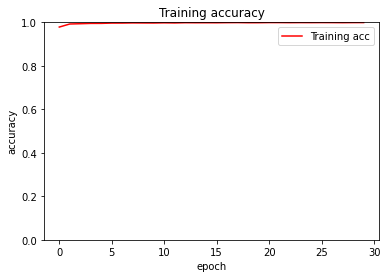

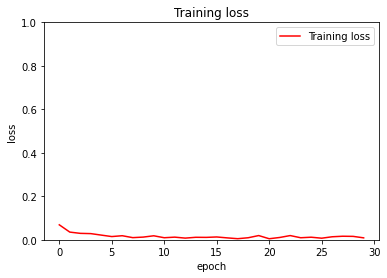

In [ ]:
#save model
model.save('Wholedataset_8layers.h5')
print('model h5 saved')
# model.save_weights('weights'+top_model_weights_path)

start = datetime.datetime.now()
(train_loss, train_accuracy) = model.evaluate( 
    train_generator,use_multiprocessing=True)
print('[INFO] accuracy: {:.2f}%'.format(train_accuracy * 100)) 
print('[INFO] Loss: {}'.format(train_loss)) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time spent evaluating:', elapsed)

#Graphing our training and validation
acc = history.history['acc']
#     val_acc = history.history['val_acc']
loss = history.history['loss']
#     val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.figure(figsize=(14,4))
plt.plot(epochs, acc, 'r', label='Training acc')
#     plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(epochs, loss, 'r', label='Training loss')
#     plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.ylim(0,1)
plt.show()

start = datetime.datetime.now()
preds = np.round(model.predict(train_generator),0)
print('rounded test labels',preds)
end = datetime.datetime.now()
elapsed= end-start
print ('Time to predict: ', elapsed)




In [12]:
model = load_model('Wholedataset_8layers.h5', custom_objects={'LeakyReLU': tf.keras.layers.LeakyReLU})

In [13]:
start = datetime.datetime.now()
preds = np.round(model.predict(train_generator),0)
print('rounded test labels',preds)
end = datetime.datetime.now()
elapsed= end-start
print ('Time to predict: ', elapsed)

rounded test labels [[0. 0. 1.]
 [0. 0. 1.]
 [0. 0. 1.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]
Time to predict:  0:15:31.465654


,Classes,Precision,Recall,Specificity,Accuracy,F1,ROC AUC,PRC AUC
0,Chest x-ray,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,No x-ray,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,X-ray,1.0,1.0,1.0,1.0,1.0,1.0,1.0


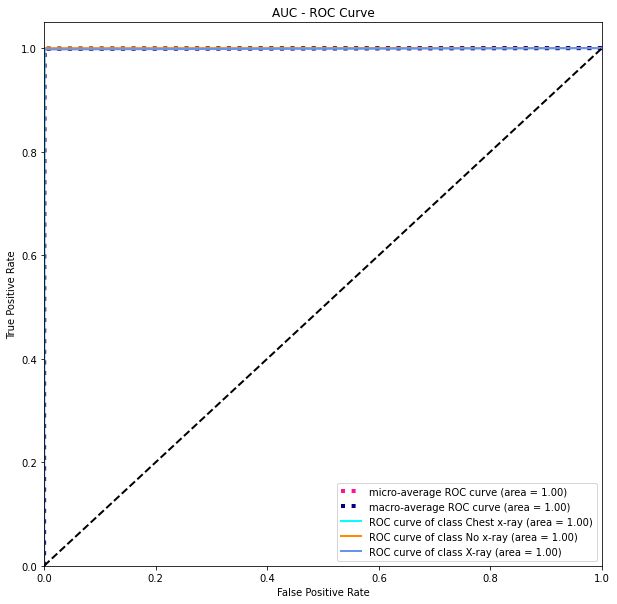

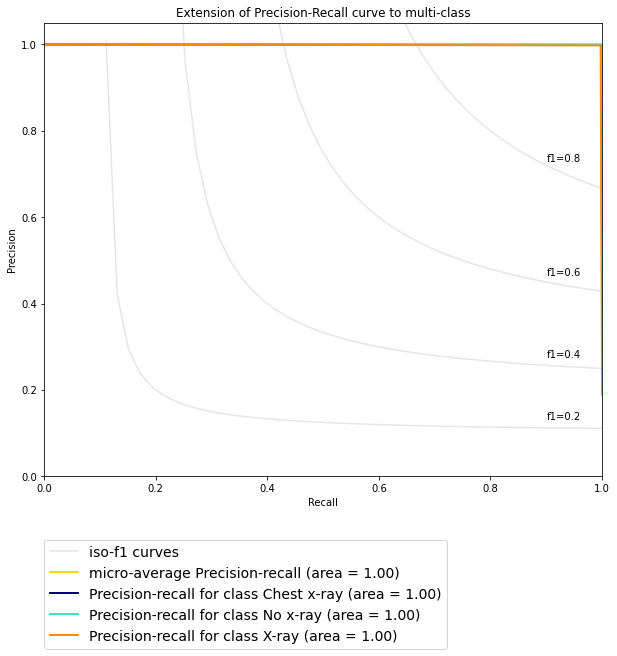

In [15]:
save_path = '/scratch/v_project/diagnosticos/pre_processing/CNN/saida/wholedataset'

classes = ['Chest x-ray','No x-ray','X-ray']
metricas = multiclass_metrics.get_metrics(train_labels, preds, columns=classes,save_path=save_path)
# df_metricas = pd.concat([df_metricas,metricas])
# df_metricas.to_csv('wholedataset_8layers_metrics',index=False)
display(metricas)

multiclass_metrics.plot_graphics(train_labels,preds, class_names=classes,save_path=save_path)

# print('Métricas')
# display(metricas)